## Part 2: 🛠️ Enhancing the Chatbot with Tools¶
- To handle queries our chatbot can't answer "from memory", we'll integrate a web search tool. Our bot can use this tool to find relevant information and provide better responses.
- Requirements¶
Before we start, make sure you have the necessary packages installed and API keys set up:

- First, install the requirements to use the Tavily Search Engine, and set your TAVILY_API_KEY

In [1]:
%%capture --no-stderr 
%pip install -U tavily-python langchain_community


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### API Key Setup

In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("TAVILY_API_KEY")

This code securely sets up the Tavily API key for web searches by:

Checking if the key exists in environment variables
If not, prompting the user to enter it securely

Using TavilySearchResults Method

In [5]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What is 'node' in LangGraph?")

[{'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n[](https://langchain-ai.github.io/langgraph/concepts/low_level/#__codelineno-7-1)fromlangchain_core.runnablesimport RunnableConfig [...] LangGraph Glossary¶\nGraphs¶\nAt its core, LangGraph models agent workflows as graphs. You define the behavior of your agents using three key components:\n\n\nState: A shared data structure that represents the current snapshot of your application. It can be any Python type, but is typically a TypedDict or Pydantic BaseModel.\n\n\nNodes: Python functions that encode the logic of your agents. They 

This creates a search tool that:

Uses Tavily's search API
Limits results to 2 entries for concise responses
Is stored in a list for use by the AI

- The results are page summaries our chat bot can use to answer questions.

- Next, we'll start defining our graph. The following is all the same as in Part 1, except we have added bind_tools on our LLM. This lets the LLM know the correct JSON format to use if it wants to use our search engine.

### Creating the Graph Structure

In [6]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# StateGraph is a graph of states, where each state is a dictionary of messages.
# The graph is built by adding messages to the states, and the graph is traversed by calling the LLM with the current state.
class State(TypedDict):
    messages: Annotated[list, add_messages]
    
    
graph_builder = StateGraph(State)


#Node: "node" in LangGraph is a state in the graph, which is a dictionary of messages.
# The graph is built by adding messages to the states, and the graph is traversed by calling the LLM with the current state.
llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state:State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node('chatbot', chatbot)

Next we need to create a function to actually run the tools if they are called. We'll do this by adding the tools to a new node.

Below, we implement a BasicToolNode that checks the most recent message in the state and calls tools if the message contains tool_calls. It relies on the LLM's tool_calling support, which is available in Anthropic, OpenAI, Google Gemini, and a number of other LLM providers.

We will later replace this with LangGraph's prebuilt ToolNode to speed things up, but building it ourselves first is instructive.

- This sets up the graph structure where:

- State defines the format of data flowing through the graph
- messages holds the conversation history
- StateGraph manages the flow between different components

- This creates the chatbot by:

- Initializing Claude 3.5 as the LLM
- Binding the search tool to the LLM
- Creating a function to process messages
- Adding it as a node in the graph

### Tool Node Implementation

In [7]:
# Import required libraries
import json
from langchain_core.messages import ToolMessage

class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        # Create a dictionary mapping tool names to tool objects for easy lookup
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # Check if there are messages in the input and get the last message
        # Using walrus operator ':=' for assignment within the if statement
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")

        # Initialize list to store results from tool executions
        outputs = []

        # Iterate through each tool call requested in the message
        for tool_call in message.tool_calls:
            # Execute the requested tool with provided arguments
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            
            # Create a ToolMessage with the tool's response
            # Convert the result to JSON string for consistency
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),  # Serialize result to JSON
                    name=tool_call["name"],           # Name of the tool used
                    tool_call_id=tool_call["id"],     # Unique ID for this tool call
                )
            )
        
        # Return the tool outputs in the expected message format
        return {"messages": outputs}

# Create an instance of BasicToolNode with our search tool
tool_node = BasicToolNode(tools=[tool])

# Add the tool node to our graph with name "tools"

graph_builder.add_node("tools", tool_node)

- This node:

Manages tool execution
Processes tool requests from the LLM
Returns results in a format the LLM can understand

With the tool node added, we can define the conditional_edges.

Recall that edges route the control flow from one node to the next. Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state. These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.

Below, call define a router function called route_tools, that checks for tool_calls in the chatbot's output. Provide this function to the graph by calling add_conditional_edges, which tells the graph that whenever the chatbot node completes to check this function to see where to go next.

The condition will route to tools if tool calls are present and END if not.

Later, we will replace this with the prebuilt tools_condition to be more concise, but implementing it ourselves first makes things more clear.

###  Routing Logic

In [10]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

- This function:

Checks if the LLM wants to use tools
Routes the flow accordingly
Ends the conversation if no tools are needed

Notice that conditional edges start from a single node. This tells the graph "any time the 'chatbot' node runs, either go to 'tools' if it calls a tool, or end the loop if it responds directly.

Like the prebuilt tools_condition, our function returns the END string if no tool calls are made. When the graph transitions to END, it has no more tasks to complete and ceases execution. Because the condition can return END, we don't need to explicitly set a finish_point this time. Our graph already has a way to finish!

Let's visualize the graph we've built. The following function has some additional dependencies to run that are unimportant for this tutorial.

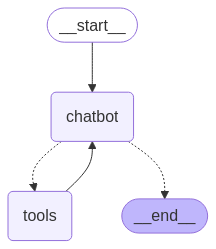

In [11]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [12]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: What do you know about LangGraph?
Assistant: [{'text': "To provide you with accurate and up-to-date information about LangGraph, I'll need to search for the latest details. Let me do that for you.", 'type': 'text'}, {'id': 'toolu_01HPGBaJSpa7cLuWLxNnyJCV', 'input': {'query': 'LangGraph AI tool'}, 'name': 'tavily_search_results_json', 'type': 'tool_use'}]
Assistant: [{"title": "LangGraph Quickstart - GitHub Pages", "url": "https://langchain-ai.github.io/langgraph/tutorials/introduction/", "content": "[](https://langchain-ai.github.io/langgraph/tutorials/introduction/#__codelineno-9-1)Assistant: LangGraph is a library designed to help build stateful multi-agent applications using language models. It provides tools for creating workflows and state machines to coordinate multiple AI agents or language model interactions. LangGraph is built on top of LangChain, leveraging its components while adding graph-based coordination capabilities. It's particularly useful for developing more co